# Solução as Questões 1 e 2 da prova


Este notebook vai apresentar uma discussão sobre a solução das Questões 1 e 2 da prova de robótica e desenvolver código inicial que será *depois* 

## Questão 1  (3.3 pontos)

#### O que você deve fazer:

Modifique o código para **escrever na imagem** sempre que o seu cão designado estiver em cima da cadeira. Você precisa colocar um aviso em texto de que o cão está em cima da cadeira, e também precisa desenhar um retângulo adicional na cor vermelha ao redor do cão de interesse.

Um cão está em cima da cadeira quando ele está  acima da cadeira na imagem e seu centro está contido dentro dos limites horizontais da cadeira, como na figura abaixo.

#### Orientações

Execute o programa `q1/q1.py`. Este exercício **não precisa** de ROS

Você vai notar que este programa roda o vídeo `dogs_chairs.mp4`. Caso seu download não tenha dado certo, baixe o vídeo da pasta `robot20/media` no Github.

![](./exemplo_imagem_q1.png)

Este programa também usa a rede `MobileNet` para classificar os objetos da imagem. 

#### O que você deve fazer:

Modifique o código para **escrever na imagem** sempre que o seu cão designado estiver em cima da cadeira. Você precisa colocar um aviso em texto de que o cão está em cima da cadeira, e também precisa desenhar um retângulo adicional na cor vermelha ao redor do cão de interesse.

Um cão está em cima da cadeira quando ele está  acima da cadeira na imagem e seu centro está contido dentro dos limites horizontais da cadeira, como na figura abaixo.


![](./em_cima_definicao.png)

**Qual é meu cão designado?**

Escreva na prova seu número de RA (registro de aluno). Se seu número de RA for *par*, seu cão será o amarelo. Se seu número de RA for *ímpar*, seu cão designado será o roxo.


|Resultado| Conceito| 
|---|---|
| Não executa | 0 |
| Consegue identificar se algum cão está em cima da cadeira  | 1.5 |
| Realiza algum trabalho para diferenciar entre os cães, mas resultado não é perfeito | 2.3 |
| Aponta sempre corretamente o cão | 3.3 | 

Casos intermediários ou omissos da rubrica serão decididos pelo professor.

# Questão 1 - Explicação da solução

Esta é apenas uma explicação para que seja mais fácil entender e estudar. Na prova dá para fazer de forma muito mais sucinta

O enunciado deixa claro que precisamos resolver algumas questões:
1. Existe cadeira na imagem?
2. Existe cão na imagem? 
3. O cão é da cor certa?
4. O centro do cão está contido na base da cadeira? 

Vamos criar algumas funções neste notebook que depois serão inseridas no arquivo `q1/q1.py` como pede a questão.

## Imagens de testes

O objetivo do código é ser testado direto no arquivo Python fornecido, Mas vamos apenas ler algumas imagens de testes para poder desenvolver o algoritmo.

In [1]:
from __future__ import print_function, division

import cv2
import numpy as np
import imlib
import os
import os.path
import matplotlib.pyplot as plt
import q1
%matplotlib inline

print("Versao da Cv2 ", cv2.__version__)
import sys
print("Versao do Python", sys.version)

Rodando Python versão  3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
OpenCV versão:  4.1.1
Diretório de trabalho:  /home/borg/catkin_ws/src/prova1_2020/q1
Versao da Cv2  4.1.1
Versao do Python 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [2]:
!ls

'Color picker Dogs.ipynb'   auxiliar.py     dogs_yellow.png	    lines.png
 Solucao_Q1_Q2.ipynb	    dogs_nada.png   em_cima_definicao.png   q1.py
 __pycache__		    dogs_pink.png   exemplo_imagem_q1.png


In [3]:
def multiplot(imgs, legenda):
    """ Função """
    fig, axes = plt.subplots(1,len(imgs), figsize=(24,8))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
        return
    for i in range(len(imgs)):
        axes[i].imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
        

In [4]:
q1_img_names = "dogs_nada.png  dogs_pink.png  dogs_yellow.png".split()

In [5]:
q1_img = [cv2.imread(filename) for filename in q1_img_names]

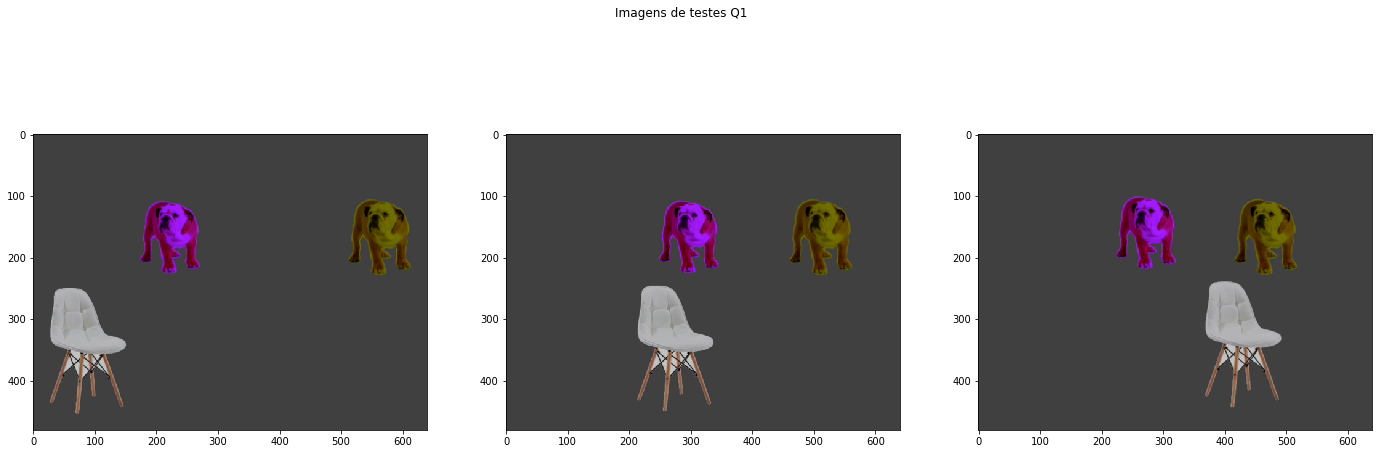

In [6]:
multiplot(q1_img, "Imagens de testes Q1")

### Existem cães e cadeiras na imagem?

Vamos criar a função `q1_solution()`  que depois será transportada para o arquivo do q1.py. Lembremos que ele precisa receber os resultados da rede neural e também o *frame* para escrever por cima.

A resposta só precisa funcionar quando um cão da cor certa e uma cadeira forem vistos simultaneamente.

Lembremos que `resultados` é uma lista de tuplas, e cada tupla tem o seguinte formato:

    ("categoria", confiança, (x1, y1),(x2,y2))
    
Sabemos que $(x_1, y_1)$  e $(x_2, y_2)$ são os limites da caixa que contém o objeto da categoria identificada.

## Vamos examinar o código fornecido

Os trechos de código foram trazidos de `q1.py` para análise

In [7]:
frame = q1_img[1] 

### O código abaixo foi tirado de q1.py e posto aqui só para fins de explicação
q1.net = cv2.dnn.readNetFromCaffe(q1.proto, q1.model)

q1.CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
    "sofa", "train", "tvmonitor"]   

q1.CONFIDENCE = 0.7
q1.COLORS = np.random.uniform(0, 255, size=(len(q1.CLASSES), 3))
###
saida, resultados = q1.detect(frame)


[INFO] computing object detections...
[INFO] chair: 98.62%
[INFO] dog: 78.24%
[INFO] person: 70.53%


### Array de resultados da MobileNet

Lembrando como era o *array* de resultados:

In [8]:
resultados

[('chair', 98.621445894241333, (201, 242), (344, 447)),
 ('dog', 78.240692615509033, (467, 107), (561, 231)),
 ('person', 70.532047748565674, (251, 112), (344, 221))]

Cada valor segue o formato:
```python
    ('chair', 98.621445894241333, (201, 242), (344, 447))
```


Temos, na ordem:
* categoria
* confiança
* (x1, y1) - primeiro ponto que define o retângulo que contém o objeto
* (x2, y2) - segundo ponto que define o retângulo que contém o objeto

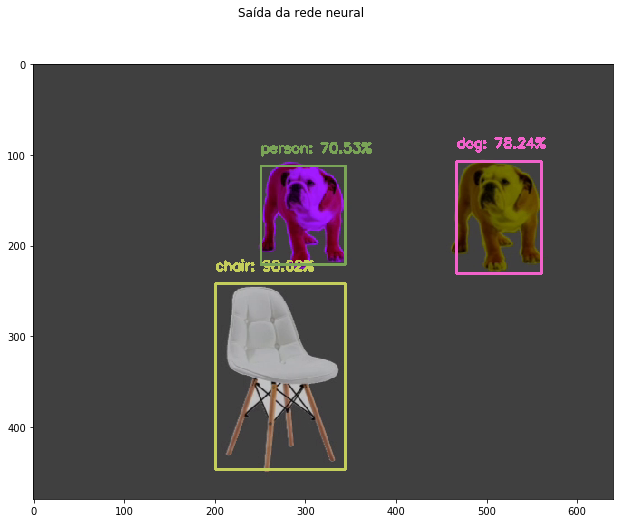

In [9]:
multiplot([saida], "Saída da rede neural")

## Filtragem de cores



O notebook <a href="Color picker Dogs.ipynb">Color picker Dogs.ipynb</a> detalha como foram encontradas as cores para as máscaras magentas e amarelas.

Chegamos aos seguintes valores para o `inRange`.

In [10]:
from numpy import array, uint8
yellow = [array([19,  50,  50], dtype=uint8),array([29, 255, 255], dtype=uint8) ]
magenta = [array([128,  50,  50], dtype=uint8),array([138, 255, 255], dtype=uint8)] 

### Contagem de pixels 

Para saber se o cão é amarelo ou magenta, vamos contar a quantidade de pixels amarelos ou magenta na máscara

In [11]:
def count_pixels(mask, ponto1, ponto2, txt_color):
    """ Recebe uma mascara binaria e 2 pontos e conta quantos pixels são brancos na mascara"""
    x1, y1 = ponto1
    x2, y2 = ponto2

    font = cv2.FONT_HERSHEY_SIMPLEX 
    # Selecionando só a região da imagem com o cachorro
    submask = mask[y1:y2,x1:x2]
    # Somando os pixels 255 e dividindo por 255 para saber quantos são
    pixels = np.sum(submask)/255
    # O resto é só plot
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    cv2.rectangle(rgb_mask, ponto1, ponto2, (255,0,0), 3)
    cv2.putText(rgb_mask, "%s:%d"%(txt_color, pixels), (int((x1+x2)/2), int((y1+y2)/2)), font, 1, (0,255,0),1,cv2.LINE_AA)
    return pixels, rgb_mask
    #plt.imshow(submask, cmap="Greys_r", vmin=0, vmax=255)
    #plt.title("(%d , %d) (%d,%d)"%(x1, y1, x2, y2))
    #plt.show()
    

## A solução propriamente dita

In [12]:
resultados

[('chair', 98.621445894241333, (201, 242), (344, 447)),
 ('dog', 78.240692615509033, (467, 107), (561, 231)),
 ('person', 70.532047748565674, (251, 112), (344, 221))]

In [13]:
def plota_contagem(rgb, texto):
    plt.imshow(rgb)
    plt.title("cruzamento retângulo x máscara %s"%(texto))
    plt.show()
    
def classifica_cadeira(dog, chair, frame):
    """ Analisa se o dog está em cima da cadeira
        de acordo com a regra da prova. 
        Se estiver, imprime mensagem na tela *e* deixa o dog com retângulo vermelho
        Recebe: tuplas já encontradas com o dog e a chair
    """
    dog_p1 = dog[2]
    dog_p2 = dog[3]
    center_x = (dog_p1[0] + dog_p2[0])/2
    cadeira_p1 = chair[2]
    cadeira_p2 = chair[3]
    
    font = cv2.FONT_HERSHEY_SIMPLEX 

    if cadeira_p1[0] < center_x < cadeira_p2[0]: # x: Se o centro do cão estiver dentro da área da cadeira
        if min(dog_p1[1], dog_p2[1]) < max(cadeira_p1[1], cadeira_p2[1]): # y: se o cao estiver acima da cadeira:
            # Lembrem-se que na OpenCV o canto superior esq. é (0,0) e as coordenadas crescem para direita 
            # e para baixo
            cv2.putText(frame, "Cao sobre a cadeira", (50, 50), font, 1, (0, 0, 255),1,cv2.LINE_AA)
            cv2.rectangle(frame, dog_p1, dog_p2, (0,0,255), 3)
    return frame


def q1_solution(resultados, frame):
    # Variaveis de descricao da cena
    chair = None
    dogs = []
    dog_categories = ["dog", "person"]
    dog_magenta = None
    dog_yellow = None
    
    # Percorre os resultados da rede neural
    for r in resultados:
        if r[0] == "chair":
            chair = r
        if r[0] in dog_categories:
            dogs.append(r)
    print("dogs", dogs)
    ### Vamos classificar os cães em amarelo ou rosa, se houver
    if len(dogs)>=1:
        frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        # Máscara para filtra amarelo
        mask_yellow = cv2.inRange(frame_hsv, yellow[0], yellow[1])
        # Máscara para filtrar magenta
        mask_magenta = cv2.inRange(frame_hsv, magenta[0], magenta[1])
        for d in dogs:
            qtd_amarelo, rgb_amarelo = count_pixels(mask_yellow.copy(), d[2], d[3], "Am.")
            plota_contagem(rgb_amarelo, "Amarelo")
            qtd_magenta, rgb_magenta = count_pixels(mask_magenta.copy(), d[2], d[3], "Mag.")
            plota_contagem(rgb_magenta, "Magenta")
            if qtd_amarelo > 50: # 50 foi escolhido para rejeitar eventuais ruidos
                dog_yellow = d
            elif qtd_magenta > 50:
                dog_magenta = d
    if chair is not None:
        if dog_magenta is not None:
            classifica_cadeira(dog_magenta, chair, frame)        
        if dog_yellow is not None:
            classifica_cadeira(dog_yellow, chair, frame)


        
    
    

dogs [('dog', 78.240692615509033, (467, 107), (561, 231)), ('person', 70.532047748565674, (251, 112), (344, 221))]


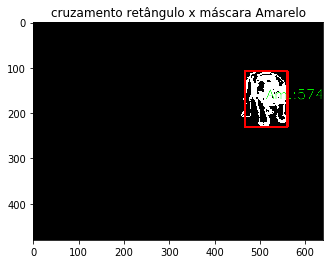

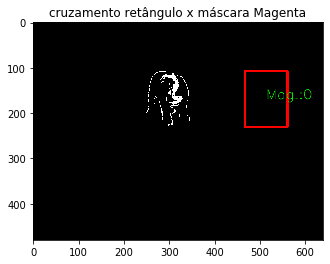

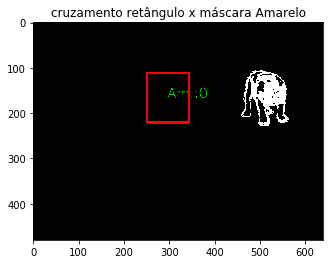

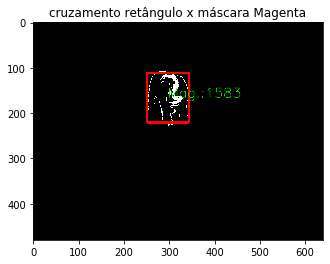

In [14]:
q1_solution(resultados, frame)

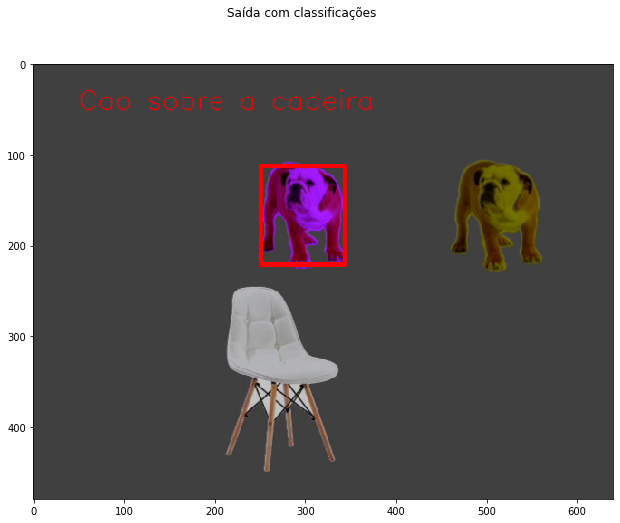

In [16]:
multiplot([frame], "Saída com classificações")

#### Validação nas 3 imagens

[INFO] computing object detections...
[INFO] chair: 98.45%
dogs []
[INFO] computing object detections...
[INFO] chair: 98.91%
[INFO] dog: 77.37%
dogs [('dog', 77.3651123046875, (469, 108), (559, 229))]


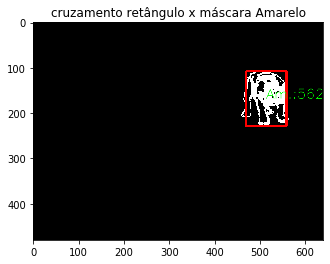

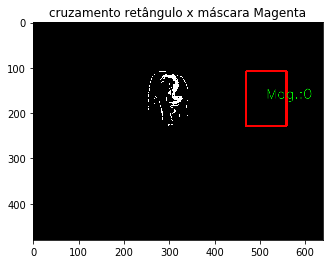

[INFO] computing object detections...
[INFO] chair: 99.01%
[INFO] person: 80.57%
dogs [('person', 80.570358037948608, (230, 108), (321, 215))]


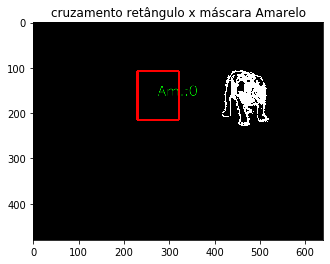

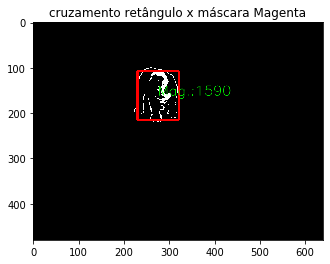

In [17]:
for img in q1_img:
    saida, resultados = q1.detect(img)
    q1_solution(resultados, img)

### Teste nas imagens de testes

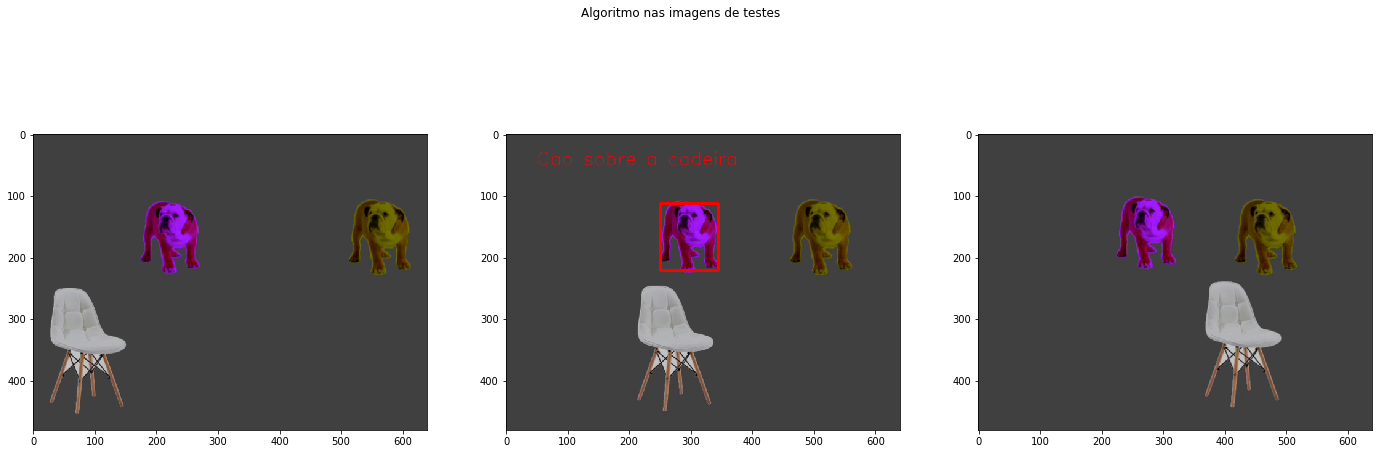

In [18]:
multiplot(q1_img, "Algoritmo nas imagens de testes")

### Conclusão

Agora a função acima pode ser inserida nos arquivos `.py`.